In [4]:
%load_ext autoreload
%autoreload 2


import numpy as np
import pandas as pd
from math import sqrt
import scipy as sp

import seaborn as sns
sns.set()
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error


from sksurv.util import Surv
from sksurv.linear_model import CoxPHSurvivalAnalysis
from sksurv.ensemble import RandomSurvivalForest
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sksurv.metrics import concordance_index_censored


# Our very own survLime!
import survLime
from survlimepy.load_datasets import Loader 
#from survLime import survlime_explainer


dataset = 'lung'
loader = Loader(dataset_name=dataset)
x,events, times = loader.load_data()


train, test = loader.preprocess_datasets(x, events, times, random_seed=0, standarize=True)
events_train = [x[0] for x in train[1]]
times_train  = [x[1] for x in train[1]]

events_test = [x[0] for x in test[1]]
times_test  = [x[1] for x in test[1]]


model = RandomSurvivalForest(n_estimators=1000,
                                        min_samples_leaf=5,
                                        min_samples_split=5,
                                        min_weight_fraction_leaf=0.025,
                                        max_depth=4,
                                        n_jobs=-1, random_state=42)
model = CoxPHSurvivalAnalysis(alpha=0.001)
#model = RandomSurvivalForest()
model.fit(train[0], train[1])
x['event'] = events
test[0]['event'] = [x[0] for x in test[1]]
test[0][['ph.ecog_2.0', 'event']].value_counts()
x[['ph.ecog','event']].value_counts()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


ph.ecog  event
1.0      True     82
2.0      True     44
0.0      True     37
1.0      False    31
0.0      False    26
2.0      False     6
dtype: int64

In [84]:
model.coef_

array([ 0.40951595, -0.17411605,  0.28661911,  0.08567909, -0.18488214,
        0.03344272, -0.0298342 ,  0.91350472,  0.8808115 ,  0.60335088])

In [74]:
test[0].columns

Index(['inst', 'age', 'sex', 'ph.karno', 'pat.karno', 'meal.cal', 'wt.loss',
       'ph.ecog_1.0', 'ph.ecog_0.0', 'ph.ecog_2.0', 'ph.ecog_3.0', 'event'],
      dtype='object')

In [14]:
from tqdm import tqdm
def compute_boot_c_index(event_indicator, event_time, estimate, num_boot_rep, concordance_fct):
    total_individuals = len(event_indicator)
    boot_c_index = []
    for j in tqdm(range(num_boot_rep)):
       # import ipdb;ipdb.set_trace()
        idx = np.random.choice(np.arange(total_individuals), size=total_individuals, replace=True)
        event_indicator_boot = np.array([event_indicator[i] for i in idx])
        event_time_boot = np.array([event_time[i] for i in idx])
        if sum(event_indicator_boot)>0:
            estimate_boot = np.array([estimate[i] for i in idx])
            c_index_boot = concordance_fct(event_indicator_boot, event_time_boot, estimate_boot)[0]
            boot_c_index.append(c_index_boot)
    boot_c_index = np.sort(np.array(boot_c_index))
    return boot_c_index

test_preds = model.predict(test[0])
result = compute_boot_c_index(events_test, times_test, test_preds, 100, concordance_index_censored)

100%|███████████████████████████| 100/100 [00:00<00:00, 3598.16it/s]


0.9630505545420949

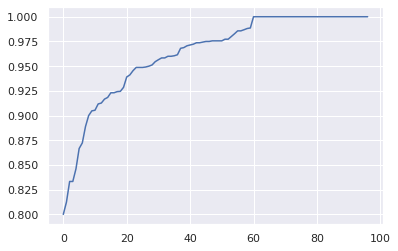

In [16]:
plt.plot(result)
np.mean(result)


In [ ]:
from sklearn.metrics.pairwise import euclidean_distances

compt_weights = pd.read_csv(f'/home/carlos.hernandez/PhD/survlime-paper/survLime/computed_weights_csv/exp3/rsf_exp_{dataset}_surv_weights_na_rand_seed_0.csv')
coef = model.coef_

dist = euclidean_distances(compt_weights, coef.reshape(1,-1))
closest = list(dist).index(min(dist))
furthest = list(dist).index(max(dist))


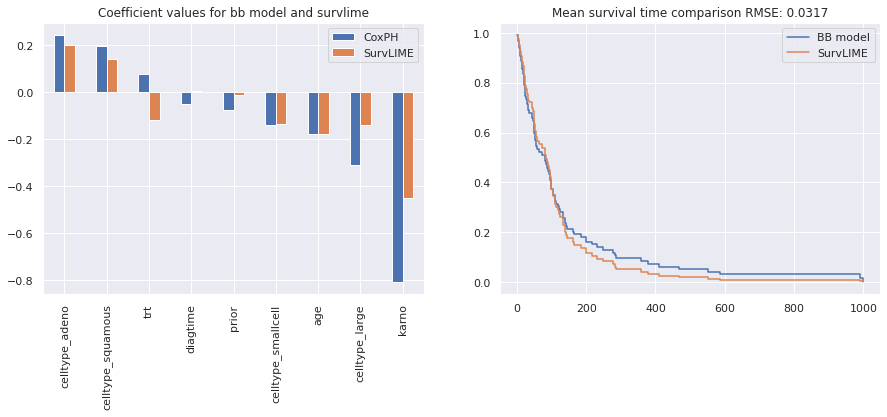

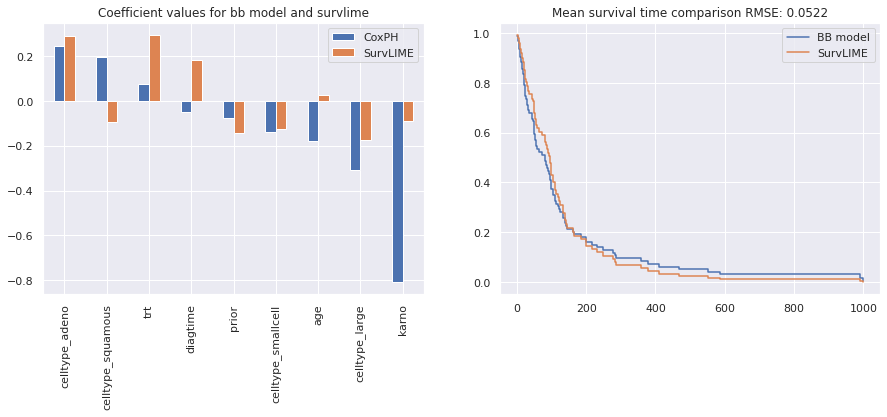

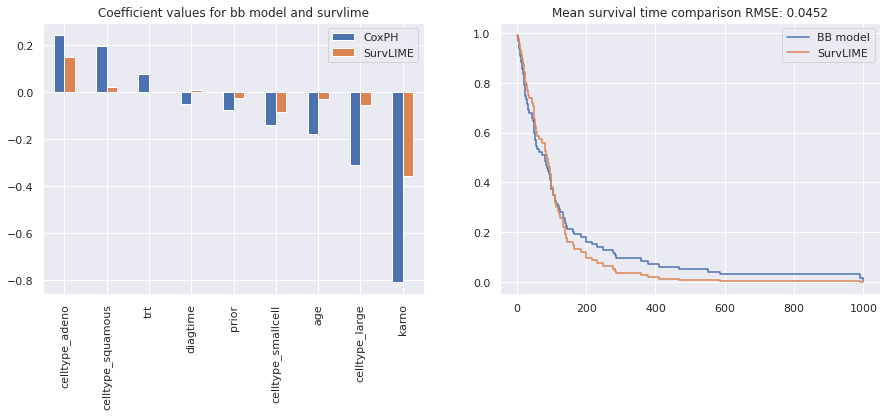

In [10]:
compare_survival_times(model, compt_weights.iloc[closest], train[0], train[1], test[0])
compare_survival_times(model, compt_weights.iloc[furthest], train[0], train[1], test[0])
compare_survival_times(model, compt_weights.mean(), train[0], train[1], test[0])

In [7]:
def change_name(name):
    if name=='cox':
        return 'CoxPH'
    elif name=='rsf':
        return 'RSF'
    elif name=='xgb':
        return 'XGB'
    elif name=='deepsurv':
        return 'DeepSurv'
    elif name=='deephit':
        return 'DeepHit'

### This part updates the colours of the plots with the new palettes

  0%|                                                                                                                                                                                       | 0/100 [00:00<?, ?it/s]
Traceback (most recent call last):
  File "/tmp/ipykernel_1692792/3630316604.py", line 22, in <module>
    surv_volume[i] = compt_weights.to_numpy()
ValueError: could not broadcast input array from shape (26,4) into shape (17,4)
 18%|███████████████████████████████▏                                                                                                                                             | 18/100 [00:00<00:00, 128.67it/s]
Traceback (most recent call last):
  File "/tmp/ipykernel_1692792/3630316604.py", line 22, in <module>
    surv_volume[i] = compt_weights.to_numpy()
ValueError: could not broadcast input array from shape (26,4) into shape (17,4)
  0%|                                                                                                               

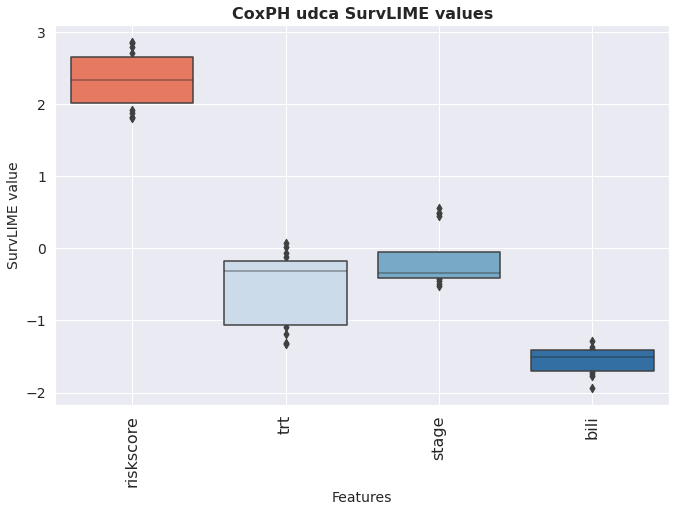

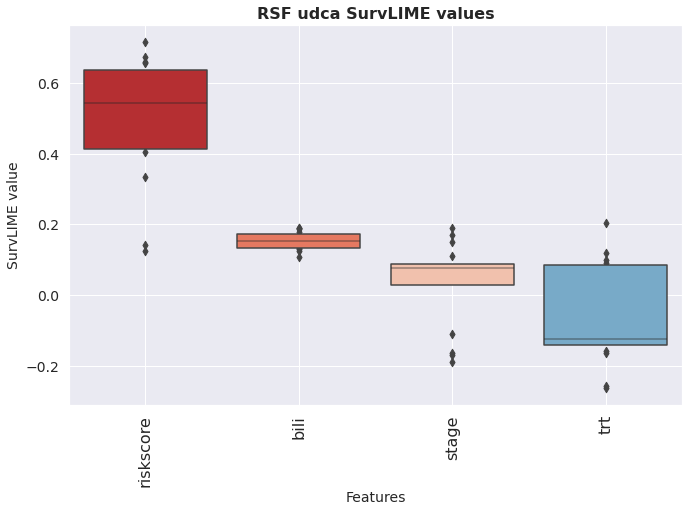

In [20]:
from tqdm import tqdm

w_path = f'/home/carlos.hernandez/PhD/survlime-paper/survLime/computed_weights_csv/exp3/'

models = ['cox','rsf','xgb','deepsurv','deephit'] # 'deephit','deepsurv', 'cox', 'xgb'
datasets = ['udca']# 'lung', 'veterans', 'udca'] # 'pbc'
length = 100
surv_volume = np.ndarray((length, 17, 4))

for dataset in datasets:
    for model_type in models:
        mean_dfs = []
        good_ones = []
        #import ipdb;ipdb.set_trace()
        try:

                for i in tqdm(range(length)):
                    compt_weights = pd.read_csv(w_path+f'{model_type}_exp_{dataset}_surv_weights_na_rand_seed_{i}.csv')
                    cols= compt_weights.columns

                    compt_weights = compt_weights.dropna(axis=0)
                    surv_volume[i] = compt_weights.to_numpy()

                
                mean_dfs = np.mean(surv_volume, axis=0)
                pru = pd.DataFrame(data=mean_dfs, columns=cols)

                pru = pru.reindex(pru.median().sort_values(ascending=False).index, axis=1)
                data = pru.copy()
                median_up = {}
                median_down = {}
                threshold = 0

                for (columnName, columnData) in data.items():
                    median_value = np.median(columnData)
                    if median_value > threshold:
                        median_up[columnName] = median_value
                    else:
                        median_down[columnName] = median_value

                median_up = dict(
                    sorted(median_up.items(), key=lambda item: item[1], reverse=True)
                )
                median_down = dict(
                    sorted(median_down.items(), key=lambda item: item[1], reverse=True)
                )

                pal_up = sns.color_palette("Reds_r", n_colors=len(median_up))
                pal_down = sns.color_palette("Blues", n_colors=len(median_down))
                colors_up = {key: val for key, val in zip(median_up.keys(), pal_up)}
                colors_down = {key: val for key, val in zip(median_down.keys(), pal_down)}
                custom_pal = {**colors_up, **colors_down}
                data_reindex = data.reindex(columns=custom_pal.keys())
                data_melt = pd.melt(data_reindex)

                _, ax = plt.subplots(figsize=(11,7))
                ax.tick_params(labelrotation=90)
                p = sns.boxenplot(
                    x="variable",
                    y="value",
                    data=data_melt,
                    palette=custom_pal,
                    ax=ax,
                )
                p.set_xlabel('Features', fontsize= 14)
                p.set_ylabel('SurvLIME value', fontsize= 14)
                p.yaxis.grid(True)
                p.xaxis.grid(True)
                model_name = change_name(model_type)
                p.set_title(f'{model_name} {dataset} SurvLIME values', fontsize= 16, fontweight='bold');


                plt.xticks(fontsize=16, rotation=90)
                plt.yticks(fontsize=14, rotation=0)
                
           #     plt.savefig(f'figures/final_figures/{model_type}_{dataset}_inverted_colours.png',  bbox_inches='tight', dpi=200)

        except:
                import traceback
                traceback.print_exc()
                #print(i)


In [ ]:

w_path = f'/home/carlos.hernandez/PhD/survlime-paper/survLime/computed_weights_csv/exp3_montecarlo/'

models = ['cox','rsf','xgb','deepsurv','deephit'] # 'deephit','deepsurv', 'cox', 'xgb'
datasets = ['udca']# 'lung', 'veterans', 'udca'] # 'pbc'
length = 100
surv_volume = np.ndarray((length, 17, 4))

for dataset in datasets:
    for model_type in models:
        data = pd.read_csv(w_path+f'{model_type}_exp_{dataset}_surv_weights.csv')
        
        median_up = {}
        median_down = {}
        threshold = 0

        for (columnName, columnData) in data.items():
            median_value = np.median(columnData)
            if median_value > threshold:
                median_up[columnName] = median_value
            else:
                median_down[columnName] = median_value

        median_up = dict(
            sorted(median_up.items(), key=lambda item: item[1], reverse=True)
        )
        median_down = dict(
            sorted(median_down.items(), key=lambda item: item[1], reverse=True)
        )

        pal_up = sns.color_palette("Reds_r", n_colors=len(median_up))
        pal_down = sns.color_palette("Blues", n_colors=len(median_down))
        colors_up = {key: val for key, val in zip(median_up.keys(), pal_up)}
        colors_down = {key: val for key, val in zip(median_down.keys(), pal_down)}
        custom_pal = {**colors_up, **colors_down}
        data_reindex = data.reindex(columns=custom_pal.keys())
        data_melt = pd.melt(data_reindex)

        _, ax = plt.subplots(figsize=(11,7))
        ax.tick_params(labelrotation=90)
        p = sns.boxenplot(
            x="variable",
            y="value",
            data=data_melt,
            palette=custom_pal,
            ax=ax,
        )
        p.set_xlabel('Features', fontsize= 14)
        p.set_ylabel('SurvLIME value', fontsize= 14)
        p.yaxis.grid(True)
        p.xaxis.grid(True)
        model_name = change_name(model_type)
        p.set_title(f'{model_name} {dataset} SurvLIME values', fontsize= 16, fontweight='bold');


        plt.xticks(fontsize=16, rotation=90)
        plt.yticks(fontsize=14, rotation=0)

   #     plt.savefig(f'figures/final_figures/{model_type}_{dataset}_inverted_colours.png',  bbox_inches='tight', dpi=200)


In [143]:
mean_ind = test[0].mean()

mean_ind_0 = mean_ind.copy()
mean_ind_1 = mean_ind.copy()

mean_ind_0['ph.ecog_0.0']=0
mean_ind_0['ph.ecog_1.0']=0
mean_ind_0['ph.ecog_2.0']=0

mean_ind_1['ph.ecog_0.0']=0
mean_ind_1['ph.ecog_1.0']=1
mean_ind_1['ph.ecog_2.0']=0

comb = pd.DataFrame([mean_ind_0,mean_ind_1],columns=test[0].columns)
comb.head()


,inst,age,sex,ph.karno,pat.karno,meal.cal,wt.loss,ph.ecog_1.0,ph.ecog_0.0,ph.ecog_2.0
0,-0.417572,-0.302237,0.190874,0.022235,0.200742,-0.096249,-0.004265,0.0,0.0,0.0
1,-0.417572,-0.302237,0.190874,0.022235,0.200742,-0.096249,-0.004265,1.0,0.0,0.0


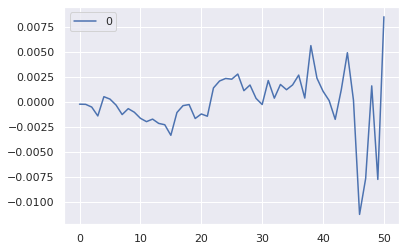

In [146]:
preds = model.predict_survival_function(comb, return_array=True)
preds.shape
plt.plot(preds[0].T-preds[1].T)
plt.legend(labels=['0','1'])

In [5]:
for feat, val in zip(model.feature_names_in_, model.coef_):
    print(f'Feature: {feat} -> {val}')

Feature: inst -> -0.13630775748661805
Feature: age -> 0.1195709287149915
Feature: sex -> -0.32001831586323604
Feature: ph.karno -> 0.0930094240697574
Feature: pat.karno -> -0.1463834131182135
Feature: meal.cal -> -0.05500542248721512
Feature: wt.loss -> -0.202162473458887
Feature: ph.ecog_1.0 -> 0.373281447934726
Feature: ph.ecog_2.0 -> 0.5246602843129659


In [7]:
test[0]

,bili,stage,riskscore,trt
133,0.052912,0.686406,-0.353131,0.942809
136,-0.594732,-1.456863,-0.627856,-1.060660
168,-0.363431,-1.456863,0.013168,-1.060660
54,-0.548472,-1.456863,-0.994155,-1.060660
56,-0.640992,0.686406,-0.902580,0.942809
144,-0.132129,0.686406,0.287892,-1.060660
7,1.533241,0.686406,2.119387,-1.060660
96,-0.548472,-1.456863,-0.719430,-1.060660
121,-0.548472,0.686406,-0.811005,-1.060660
97,-0.224650,0.686406,-0.078407,0.942809


(17, 4)